In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math 
from utils.io import baumWelch

# Defining Helper Functions

In [3]:
# Function for Encoding Game Quality 
def gameEncoding(x,conditions):
    
    # Bad Game
    if x <= conditions[0]:
        out = 0
    # Normal
    if (x > conditions[0]) and (x <= conditions[1]):
        out = 1
    # Good
    if x > conditions[1]:
        out = 2
    return out


def load_data(file):
    
    # Load Data
    data = pd.read_csv(file)
    
    # Fill Nas with 0
    data.fillna(0,inplace=True)
    
    # Locate players who actually played and had more than 0 seconds 
    gameData = data.loc[(data.did_not_play == 0) & (data.seconds_played > 0)].copy()

    # Check if games played is more than 5
    playerGames = gameData.groupby("name").count()["did_not_play"] >= 5

    # Clean It up and perpare columns for custom index
    gameData = gameData[gameData['name'].isin(playerGames[playerGames==True].index)]
    indexCols = ["field_goal_pct","threePT_pct","free_throws_pct","trb",'assists', 'steals', 'blocks','points']
    
    # Create GameValueIndex
    gameData['GameValueIndex'] = (gameData.loc[:,indexCols].sum(axis = 1) -gameData.loc[:,"turnovers"])/gameData["seconds_played"]
    
    # Quantiles for Game Quality assignment
    conditions= [np.quantile(gameData['GameValueIndex'],0.3),np.quantile(gameData['GameValueIndex'],0.7)]
    
    # 
    gameData["gameQuality"] = gameData["GameValueIndex"].apply(lambda x: gameEncoding(x,conditions))
     
    # Return Data Frame
    return gameData

In [4]:
data1718 = load_data("../data/Players_Data_2017_18.csv")
data1819 = load_data("../data/Players_Data_2018_19.csv")

In [5]:
players1718 = data1718.name.unique()
players1819 = data1819.name.unique()

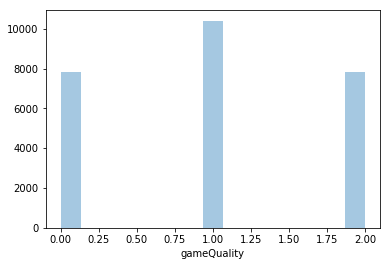

In [20]:
sns.distplot(data1718["gameQuality"], kde=False)


In [8]:
# Find players found in both seasons
players = (set(players1718) & set(players1819))

# Again filter both seasons by these players 
data17 =  data1718[data1718["name"].isin(players)].copy()
data19 = data1819[data1819["name"].isin(players)].copy()

## Running the Algorithm for Both Seasons

In [9]:
observations =["Bad", "Average", "Good"]
states = ["Cold", "Hot"]

In [65]:
emission_probs = []
for i in range(len(states)):
    for j in range(len(observations)):
        emission_probs.append(observations[j] + " " + states[i])
        
transitions = []
for i in range(len(states)):
    for j in range(len(states)):
        transitions.append(states[i] +  " " + states[j])
        
columns = transitions  + emission_probs
results = pd.DataFrame(index=players, columns=columns)

### 2017  - 18 Season

In [73]:
# Results Data Frame
results17 = pd.DataFrame(index=players, columns=columns)

for player in players:
    # "Global" priors (frome Oscars BBall Knwoledge)
    a = np.array([[0.3,0.7],[0.6,0.4]])
    b = np.array([[0.7, 0.15, 0.15],[0.1, 0.30, 0.60]])
    priors = [0.2,0.8]
    
    # Get Current Player Values
    currentPlayerOutcomes = data17.loc[data17.name == player]["gameQuality"].values
    
    # Run Baum Welch
    transition, emission = baumWelch(currentPlayerOutcomes,a,b,priors,max_iters=50)
    
    # Store Values in Results by concatenating results, axis = None indicates that arrays should be flattend
    results17.loc[player] = np.concatenate((transition,emission),axis = None)
print("Done") 

Done


### 2018 - 19 Season

In [74]:
# Results Data Frame
results19 = pd.DataFrame(index=players, columns=columns)

for player in players:
    # "Global" priors (frome Oscars BBall Knwoledge)
    a = np.array([[0.3,0.7],[0.6,0.4]])
    b = np.array([[0.7, 0.15, 0.15],[0.1, 0.30, 0.60]])
    priors = [0.2,0.8]
    
    # Get Current Player Values
    currentPlayerOutcomes = data19.loc[data19.name == player]["gameQuality"].values
    
    # Run Baum Welch
    transition, emission = baumWelch(currentPlayerOutcomes,a,b,priors,max_iters=50)
    
    # Store Values in Results
    results19.loc[player] = np.concatenate((transition,emission),axis = None)
print("Done") 

Done


## Analysis of Results

- Check overall distribution of transition and emission probabilities, to identify bad, average and outstanding players

#### Transition Probabilities

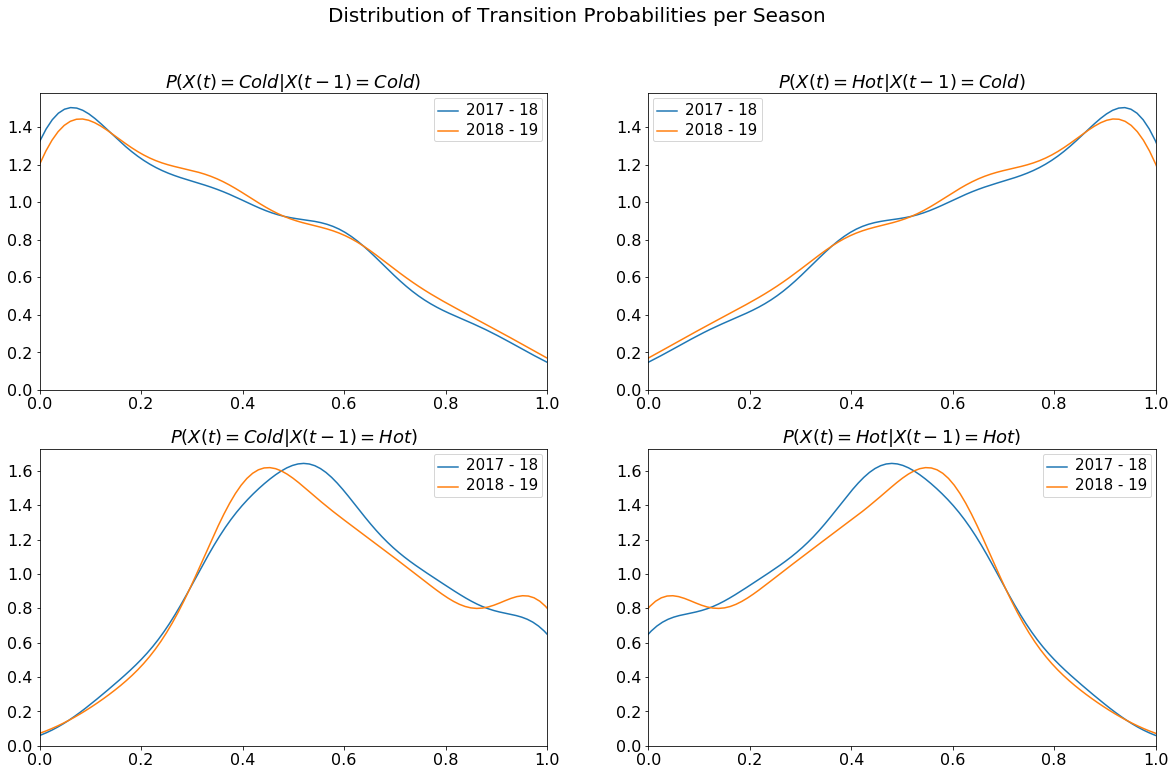

In [237]:
fig, axes = plt.subplots(ncols=2,nrows=2,  figsize=(20,12))

# This is inefficient, but I was lazy on the plane 
sns.distplot(results17[transitions[0]],hist=False, ax = axes[0][0],norm_hist=True,label = "2017 - 18");
sns.distplot(results19[transitions[0]], kde = True, hist=False, ax = axes[0][0], norm_hist=True, label = "2018 - 19");

sns.distplot(results17[transitions[1]],hist=False, ax = axes[0][1],norm_hist=True,label = "2017 - 18");
sns.distplot(results19[transitions[1]], kde = True, hist=False, ax = axes[0][1], norm_hist=True, label = "2018 - 19");

sns.distplot(results17[transitions[2]],hist=False, ax = axes[1][0],norm_hist=True,label = "2017 - 18");
sns.distplot(results19[transitions[2]], kde = True, hist=False, ax = axes[1][0], norm_hist=True, label = "2018 - 19");

sns.distplot(results17[transitions[3]],hist=False, ax = axes[1][1],norm_hist=True,label = "2017 - 18");
sns.distplot(results19[transitions[3]], kde = True, hist=False, ax = axes[1][1], norm_hist=True, label = "2018 - 19");

for i,ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=16)
    ax.set_title(f"$P(X(t) = {transitions[i].split()[1]}  |  X(t-1) = {transitions[i].split()[0]} )$", fontsize = 18)
    ax.set_xlabel("")
    ax.set_xlim(0,1)
    plt.setp(ax.get_legend().get_texts(), fontsize='15');
    
fig.suptitle(f"Distribution of Transition Probabilities per Season ",fontsize = 20);
fig.savefig(f"../report/plots/transition_probs", dpi=80)

- Basically we see, that the distributions are complements, which makes sense since they add to one
- What sucks for now is the kernel fit tries to fit it up to -0.25 and 1.25 which obviously is bullshit, I've cut the xlimits for now, but i think we could try something else here
- I don't think a Gaussian kernel makes sense here, we should check other options, I couldn't figure this distplot thing out yet
- Further, if you're in cold, for most people it's very unlikely that you stay in cold for long, the most mass in cold cold is around 0.0, so a zero chance that you will stay cold in the next game
- Accordingly, most people rebound from a bad came with higher probability than 0.5, also seen in the Cold Hot plot
- On the other hand, staying hot is a considerably rarer thing than going from cold to hot
-  It seems like it's almost a coin flip whether players will have consecutively hot games
- So we can say that good, consistent players are the ones in the right tail of the Hot - Hot plot, the ones that actually stay hot
- Eyeballing this it seems like this tail is a lot thinner than the other option: Having a Hot game followed by a cold one
- **Message: You're not good just because you recover from one cold game. What makes a good player is a high probability of staying hot!**
- Obviously, the transition probabilities alone are not conculsive, what's important is that when you're hot, you'll also have a good game, not just an average one. We will look at  this now
-  We do see some shifts in distribution, but I wouldn't put too much into it, given less games in 2018-2019 and no big changes
- Might also be indicative of "good model fit"


### Emission Probabilities

In [183]:
cold_columns = emission_probs[0:3]
hot_columns = emission_probs[]

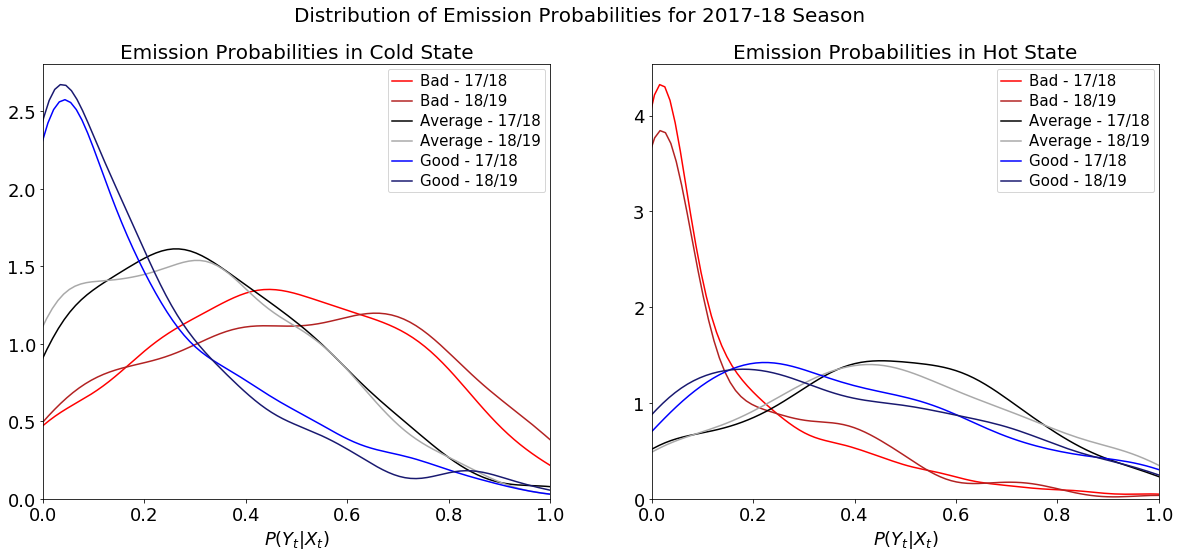

In [222]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(20,8))

colors17 = ["red", "black", "blue"]
colors19 = ["firebrick", "darkgray", "midnightblue"]

for i in range(3):
    
    # 17 - 18 
    sns.distplot(results17[emission_probs[i]],hist=False, ax = ax[0], color=colors17[i], label= f"{emission_probs[i].split()[0]} - 17/18")
    sns.distplot(results17[emission_probs[i+3]],hist=False, ax = ax[1],color=colors17[i], label= f"{emission_probs[i+3].split()[0]} - 17/18" )
    
    # 18 -19
    sns.distplot(results19[emission_probs[i]],hist=False, ax = ax[0],color=colors19[i], label= f"{emission_probs[i].split()[0]} - 18/19")
    sns.distplot(results19[emission_probs[i+3]],hist=False, ax = ax[1],color=colors19[i], label= f"{emission_probs[i+3].split()[0]} - 18/19")

                 
for a in ax:  
    a.tick_params(labelsize=18) 
    a.set_xlabel("$P(Y_t | X_t)$", fontsize = 18)
    a.set_xlim(0,1)
    plt.setp(a.get_legend().get_texts(), fontsize='15');

ax[0].set_title("Emission Probabilities in Cold State",fontsize = 20)
ax[1].set_title("Emission Probabilities in Hot State", fontsize = 20)
fig.suptitle(f"Distribution of Emission Probabilities given State ",fontsize = 20);
fig.savefig(f"../report/plots/emission_probs", dpi=80)

- We see, that for most cold players, it's almost impossible to have a good game when cold, the probability mass is around 0
- Further, having a bad game and is the most likely, while some players can also have an average game when cold
-  On the other hand, when a player is hot, on average it will be unlikely that he has a bad game, as seen in the right plot
- However, it seems like it's on average still more likely to have a average game when hot, than having a good game
- So we could say that on average, hot players are likely to have am average game at least
- 
- **Message: Really good players are the guys who will definitely perform great when hot, and who will still perform average or even good when cold** 
- Again, we do see some changes in distribution, but I wouldn't dare to make some statements about this. Maybe the Basketball God Oscar and Guillem like to mention something here 

### High Level Players 2017 - 2018
- Identify the top performers of the 2017-2018 season
- Low probabilitiy of staying cold
- High Probability of stying hot 
- high probability of having a great game, even when cold
- Almost certain to have a perfect game when hot

In [241]:
results17[(results17["Cold Cold"] < 0.15) & (results17["Hot Hot"] >= 0.5) & (results17["Good Hot"] > 0.85) & (results17["Good Cold"] >= 0.5)  ]

,Cold Cold,Cold Hot,Hot Cold,Hot Hot,Bad Cold,Average Cold,Good Cold,Bad Hot,Average Hot,Good Hot
Karl-Anthony Towns,0.11188,0.88812,0.388674,0.611326,0.0403103,0.454986,0.504703,2.01073e-07,0.0649214,0.935078
Anthony Davis,0.143563,0.856437,0.346398,0.653602,0,0.131357,0.868643,0,0.115429,0.884571
LeBron James,0.141258,0.858742,0.344644,0.655356,0,0.117109,0.882891,0,0.106818,0.893182
Hassan Whiteside,0.0697366,0.930263,0.398788,0.601212,0.062146,0.353831,0.584024,3.21145e-10,0.0608423,0.939158
Joel Embiid,0.123995,0.876005,0.351961,0.648039,0,0.184668,0.815332,0,0.0151645,0.984835
DeMarcus Cousins,0.1442,0.8558,0.345025,0.654975,0,0.117301,0.882699,0,0.098912,0.901088
Russell Westbrook,0.0451422,0.954858,0.43349,0.56651,0,0.281897,0.718103,0,0.000394782,0.999605
Stephen Curry,0.00804335,0.991957,0.353544,0.646456,0,0.451373,0.548627,0,5.86348e-05,0.999941
James Harden,0.0114515,0.988549,0.492704,0.507296,0,0.125975,0.874025,0,7.44954e-07,0.999999


- Except for Hassan Whiteside, these seem all very intuititve
- We've consistently uncovered the stars, the gus who never have a bad game, like to stay hot with a higher probability than a coin flip 
- Interestingly, even these guys only stay hot with p < 0.65, so maybe this is not what makes a good player
- It's not that you are always in the "crazy hot" mode, but rather that even when you're "cold" you just kill the others,
- And once you're hot, you'll definitley dominate the game 
- LeBron, Davis, Embiid, Harden will have a good game with p > 0.8, even when cold! That's quite astonishing
-  Do we see any changes, people who dropped or rising stars in 2018-2019?

In [242]:
results19[(results19["Cold Cold"] < 0.15) & (results19["Hot Hot"] >= 0.5) & (results19["Good Hot"] > 0.85) & (results17["Good Cold"] >= 0.5)  ]

,Cold Cold,Cold Hot,Hot Cold,Hot Hot,Bad Cold,Average Cold,Good Cold,Bad Hot,Average Hot,Good Hot
Giannis Antetokounmpo,0.118215,0.881785,0.353268,0.646732,0,0.124441,0.875559,0,0.0140102,0.98599
Anthony Davis,0.128598,0.871402,0.359343,0.640657,0.0615937,0.0778042,0.860602,0.000413463,0.0706493,0.928937
LeBron James,0.136945,0.863055,0.340937,0.659063,0,0.0816549,0.918345,0,0.0750662,0.924934
Joel Embiid,0.14312,0.85688,0.356118,0.643882,0,0.170859,0.829141,0,0.0943057,0.905694
Russell Westbrook,0.146301,0.853699,0.346294,0.653706,0,0.136406,0.863594,0,0.0984762,0.901524
Kevin Durant,0.0597438,0.940256,0.439616,0.560384,0.0457941,0.420002,0.534204,1.932e-08,0.0387691,0.961231
Stephen Curry,3.41216e-05,0.999966,0.498751,0.501249,0.0500015,0.527443,0.422556,3.93636e-25,0.0612856,0.938714
James Harden,0.0108112,0.989189,0.458554,0.541446,0,0.183817,0.816183,0,7.56355e-06,0.999992


- Giannis Obiously is one of the rising stars
- Cousins dropped out, so did Whiteside
- for the others, it looks like they stayed on top of their game!
- Now for the dreadful part: What's it like to be a bad player?

In [248]:
results19[(results19["Cold Cold"] > 0.5) & (results19["Hot Hot"] <= 0.15) & (results19["Bad Cold"] > 0.8) & (results19["Good Hot"] < 0.5)  ]

,Cold Cold,Cold Hot,Hot Cold,Hot Hot,Bad Cold,Average Cold,Good Cold,Bad Hot,Average Hot,Good Hot
Wesley Johnson,0.79851,0.20149,1,2.51516e-36,0.90074,4.55109e-10,0.0992601,0.00160656,0.994714,0.00367911
Alex Abrines,0.573739,0.426261,0.999998,1.6843e-06,1,1.16374e-11,1.38239e-11,0.363317,0.318342,0.318342
Solomon Hill,0.845891,0.154109,0.999873,0.000127208,0.8992,0.100799,1.64023e-06,0.00571979,0.821456,0.172825
Wilson Chandler,0.640842,0.359158,0.999978,2.15514e-05,0.850958,0.149042,6.33657e-21,0.00753234,0.732692,0.259776
Skal Labissiere,0.647798,0.352202,0.851551,0.148449,0.817048,0.0189858,0.163966,0.00585263,0.994147,5.18012e-13


- Well, these are the guys who almost always stay cold
- When cold, the WILL have a bad game
- and even when they are hot, they will at most be average (however, then they seem to almost always have an average game)
- But lets not forget, these guys are still NBA players, making quite a lot of money